В данном ноутбуке используется детектор из библиотеки "Torchvision".

### Импорт библиотек

In [ ]:
from typing import Callable, Dict, List, Optional, Tuple
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import cv2
import torch
import torchvision
import torchvision.transforms.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from albumentations import ShiftScaleRotate

In [ ]:
!pip install -U catalyst

     |████████████████████████████████| 368kB 12.2MB/s 
     |████████████████████████████████| 204kB 17.2MB/s 
     |████████████████████████████████| 460kB 34.9MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 


In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

### Импорт изображений и разметки к ним

In [ ]:
%%bash
download-gdrive 1_uL-c1u7zsST4azSOsvJynIGVkKMv8yx Card.zip
extract-archive Card.zip &>/dev/null

--2020-06-26 18:56:07--  https://docs.google.com/uc?export=download&confirm=t0Af&id=1_uL-c1u7zsST4azSOsvJynIGVkKMv8yx
Resolving docs.google.com (docs.google.com)... 172.217.194.102, 172.217.194.113, 172.217.194.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-8o-docs.googleusercontent.com/docs/securesc/m3vql4f4s63vngnis3l6si6hk0fnjf6m/ta1ddceofk98dmhg961iv3ce8bpiltm3/1593197700000/15598466624630128114/15889116671707323631Z/1_uL-c1u7zsST4azSOsvJynIGVkKMv8yx?e=download [following]
--2020-06-26 18:56:08--  https://doc-00-8o-docs.googleusercontent.com/docs/securesc/m3vql4f4s63vngnis3l6si6hk0fnjf6m/ta1ddceofk98dmhg961iv3ce8bpiltm3/1593197700000/15598466624630128114/15889116671707323631Z/1_uL-c1u7zsST4azSOsvJynIGVkKMv8yx?e=download
Resolving doc-00-8o-docs.googleusercontent.com (doc-00-8o-docs.googleusercontent.com)... 142.250.4.132, 2404:6800:4003:c06::84
Connect

### Подготовка данных

In [ ]:
train_df = pd.read_csv('data/train_labels.csv')
test_df = pd.read_csv('data/test_labels.csv')

In [ ]:
train_df.head()

filename  width  height  class  xmin  ymin  xmax  ymax
0   cam_image1.jpg    480     270  queen   173    24   260   137
1   cam_image1.jpg    480     270  queen   165   135   253   251
2   cam_image1.jpg    480     270    ten   255    96   337   208
3  cam_image10.jpg    960     540    ten   501   116   700   353
4  cam_image10.jpg    960     540  queen   261   124   453   370

In [ ]:
test_df.head()

filename  width  height class  xmin  ymin  xmax  ymax
0  cam_image2.jpg    960     540  king   312    30   485   249
1  cam_image2.jpg    960     540  king   514    24   694   245
2  cam_image2.jpg    960     540  king   305   263   489   519
3  cam_image2.jpg    960     540  king   515   267   704   523
4  cam_image4.jpg    960     540  jack   297    18   459   237

In [ ]:
LABELS = list(train_df['class'].unique())
N_CLASSES = len(LABELS)
LABELS, N_CLASSES

(['queen', 'ten', 'nine', 'king', 'jack', 'ace'], 6)

In [ ]:
list(test_df['class'].unique())

['king', 'jack', 'nine', 'ace', 'ten', 'queen']

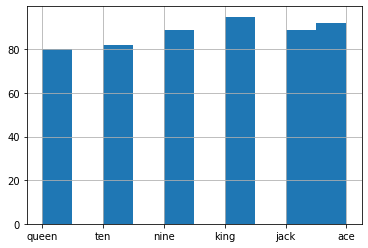

In [ ]:
train_df['class'].hist()

In [ ]:
LABELS

['queen', 'ten', 'nine', 'king', 'jack', 'ace']

### Создание Datasets

In [ ]:
class CardsDataset(Dataset):
    def __init__(self, 
                 data_frame: pd.DataFrame, 
                 path_to_data: str,
                 transforms: Optional[Callable] = None) -> None:
        self.df = data_frame
        self.filenames = self.df['filename'].unique()
        self.path = path_to_data
        self.transforms = transforms
    
    def __len__(self) -> int:
        return len(self.filenames)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        filename = self.filenames[idx]
        img = cv2.imread(self.path + filename)
        sample_df = self.df[self.df['filename'] == filename]
        bboxes = []
        labels = []
        for i in range(len(sample_df)):
            x1 = sample_df.iloc[i]['xmin'] 
            y1 = sample_df.iloc[i]['ymin'] 
            x2 = sample_df.iloc[i]['xmax'] 
            y2 = sample_df.iloc[i]['ymax'] 
            label = sample_df.iloc[i]['class']
            label = LABELS.index(label)
            bboxes.append((x1, y1, x2, y2))
            labels.append(label)
        bboxes = tuple(bboxes)
        data = {'image': img, 'bboxes': bboxes, 'labels': labels}
        if self.transforms:
            data = self.transforms(**data)
        data['image'] = F.to_tensor(data['image'])
        data['bboxes'] = torch.tensor(data['bboxes'], dtype=torch.float)
        data['labels'] = torch.tensor(data['labels'], dtype=torch.int64)
        return data


def collate_fn(batch: List[Dict[str, torch.Tensor]]) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    images = [None for _ in range(len(batch))]
    targets = [None for _ in range(len(batch))]
    for i in range(len(batch)):
        images[i] = batch[i]['image']
        targets[i] = {
            'boxes': batch[i]['bboxes'],
            'labels': batch[i]['labels']
        }
    return images, targets

In [ ]:
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

In [ ]:
train_dataset = CardsDataset(train_df, TRAIN_PATH)
test_dataset = CardsDataset(test_df, TEST_PATH)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ten queen 

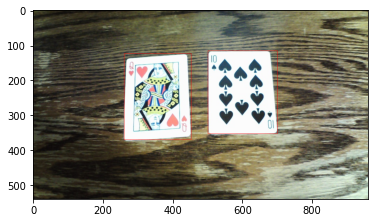

In [ ]:
# Sample image
sample = train_dataset[1]
img = sample['image'].permute(1, 2, 0).numpy()
for label in sample['labels']:
    print(LABELS[label], end=' ')
for bbox in sample['bboxes'].numpy().astype('int'):
    x1, y1, x2, y2 = bbox
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255))
plt.imshow(img[:, :, ::-1])

### Импорт предобученной модели

In [ ]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, N_CLASSES)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Заморозка "Backbone" и разморозка других слоев для обучения.

In [ ]:
for param in model.backbone.parameters():
    param.requires_grad_(False)
    
for param in model.rpn.parameters():
    param.requires_grad_(True)
    
for param in model.roi_heads.parameters():
    param.requires_grad_(True)

### Обучение

In [ ]:
%%bash
download-gdrive 1K9pVZh42VAVa_Kxywq7jolWHLbEOFbnF 40_model.pth

--2020-06-26 18:59:16--  https://docs.google.com/uc?export=download&confirm=kbwm&id=1K9pVZh42VAVa_Kxywq7jolWHLbEOFbnF
Resolving docs.google.com (docs.google.com)... 172.217.194.113, 172.217.194.139, 172.217.194.100, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-bo-docs.googleusercontent.com/docs/securesc/ibcuckb75j2dv2kf2nt9rbamle5nas75/sl27eaq88j0e8b9oqsluinmkmpiqshhv/1593197925000/15598466624630128114/09677589591342834485Z/1K9pVZh42VAVa_Kxywq7jolWHLbEOFbnF?e=download [following]
--2020-06-26 18:59:16--  https://doc-0o-bo-docs.googleusercontent.com/docs/securesc/ibcuckb75j2dv2kf2nt9rbamle5nas75/sl27eaq88j0e8b9oqsluinmkmpiqshhv/1593197925000/15598466624630128114/09677589591342834485Z/1K9pVZh42VAVa_Kxywq7jolWHLbEOFbnF?e=download
Resolving doc-0o-bo-docs.googleusercontent.com (doc-0o-bo-docs.googleusercontent.com)... 142.250.4.132, 2404:6800:4003:c06::84
Connect

In [ ]:
# Загрузка весов моей обученной модели
PATH = "/content/40_model.pth"
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [ ]:
loss_graph = []

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 40
# сохранение весов каждые n эпох
SAVE_MODEL_EVERY_EPOCHS = 10

model.to(DEVICE).train()

epoch = tqdm(range(epochs), leave=False, desc='train')
for ep in epoch:
    loss_sum = 0.
    data = tqdm(train_loader, leave=False)
    for batch in data:
        images, targets = batch
        images = list(img.to(DEVICE) for img in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        losses = model(images, targets)
        loss = (losses['loss_classifier'] + losses['loss_box_reg'] + \
            losses['loss_rpn_box_reg']).sum()
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        
        data.set_description(f'[loss = {loss.item():.4f}]')
    scheduler.step()
    loss_graph.append(loss_sum / len(train_loader))
    
    tqdm.write(f'Epoch {ep + 1}: loss = {loss_sum / len(train_loader):.4f}')
    if ep % SAVE_MODEL_EVERY_EPOCHS ==0:
      torch.save(model.state_dict(), str(ep)+"_model.pth")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Epoch 1: loss = 0.1279


Epoch 2: loss = 0.0992


Epoch 3: loss = 0.0848


Epoch 4: loss = 0.0828


Epoch 5: loss = 0.0754


Epoch 6: loss = 0.0684


Epoch 7: loss = 0.0646


Epoch 8: loss = 0.0619


Epoch 9: loss = 0.0612


Epoch 10: loss = 0.0555


Epoch 11: loss = 0.0446


Epoch 12: loss = 0.0368


Epoch 13: loss = 0.0356


Epoch 14: loss = 0.0329


Epoch 15: loss = 0.0315


Epoch 16: loss = 0.0295


Epoch 17: loss = 0.0293


Epoch 18: loss = 0.0272


Epoch 19: loss = 0.0274


Epoch 20: loss = 0.0270


Epoch 21: loss = 0.0245


Epoch 22: loss = 0.0241


Epoch 23: loss = 0.0251


Epoch 24: loss = 0.0242


Epoch 25: loss = 0.0240


Epoch 26: loss = 0.0239


Epoch 27: loss = 0.0238


Epoch 28: loss = 0.0232


Epoch 29: loss = 0.0233


Epoch 30: loss = 0.0240


Epoch 31: loss = 0.0233


Epoch 32: loss = 0.0233


Epoch 33: loss = 0.0235


Epoch 34: loss = 0.0230


Epoch 35: loss = 0.0226


Epoch 36: loss = 0.0228


Epoch 37: loss = 0.0228


Epoch 38: loss = 0.0233


Epoch 39: loss = 0.0238


Epoch 40: loss = 0.0228


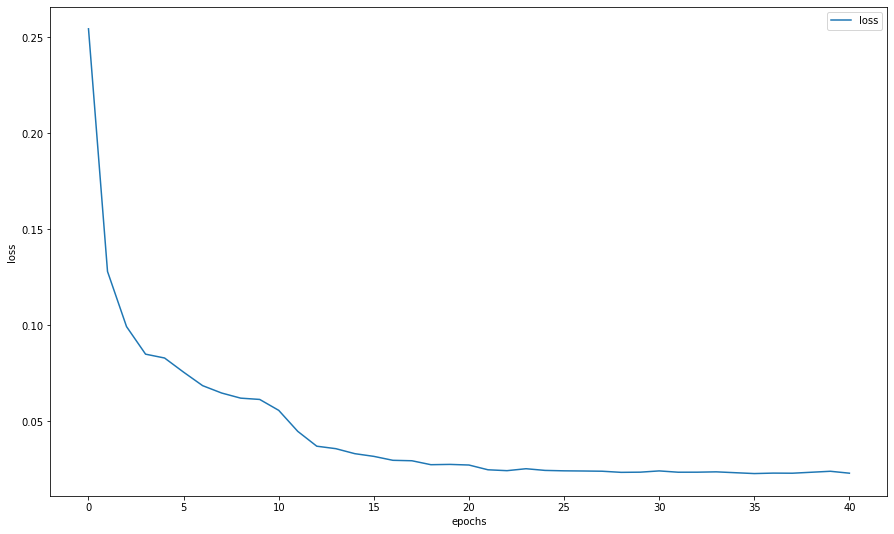

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss_graph, label="loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:

torch.save(model.state_dict(),"40_model.pth")

### Тестирование

In [ ]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,300)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2


In [ ]:
model.to(DEVICE).train()
model.eval()
it = iter(test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid rang

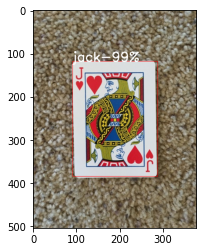

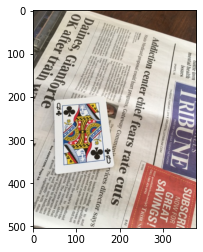

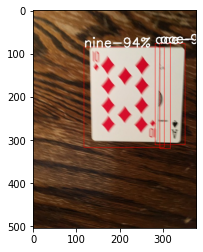

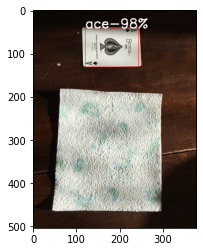

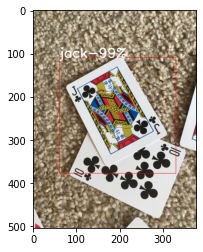

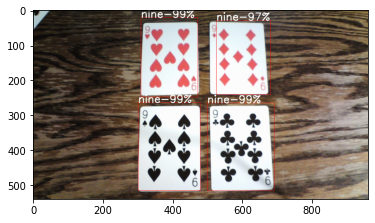

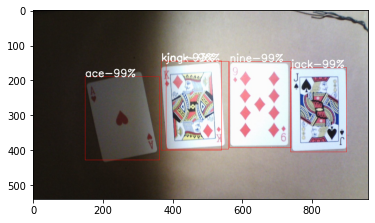

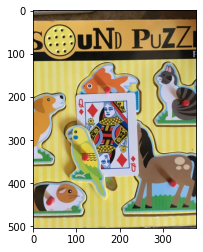

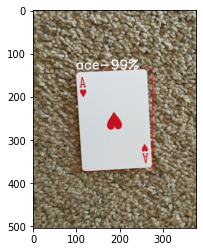

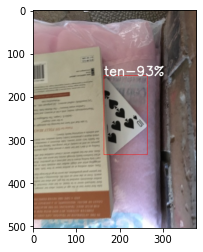

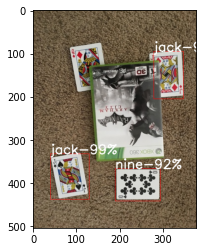

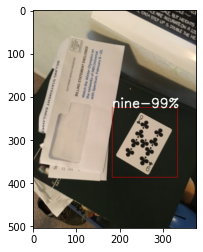

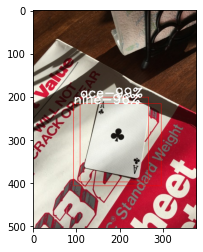

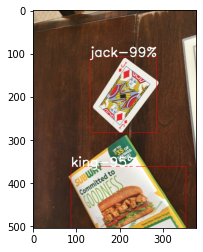

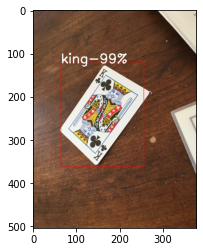

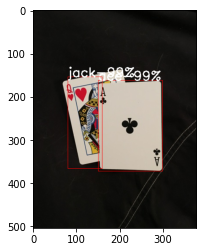

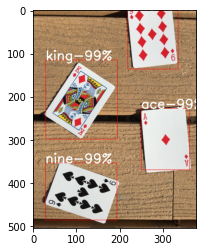

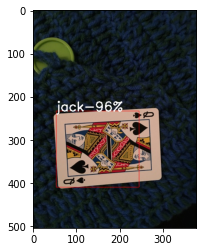

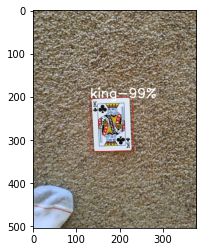

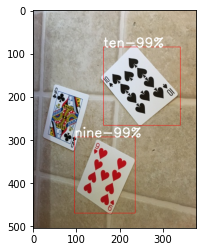

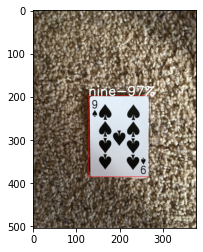

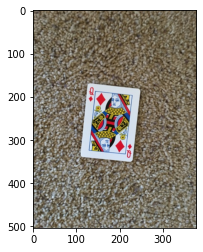

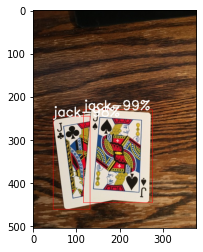

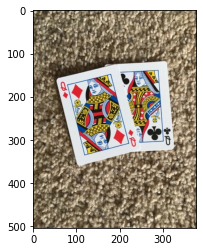

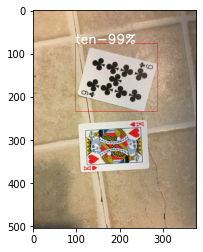

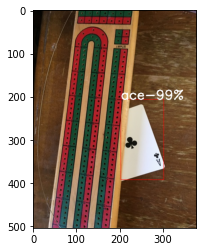

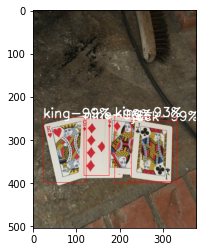

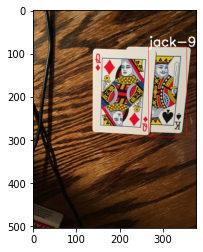

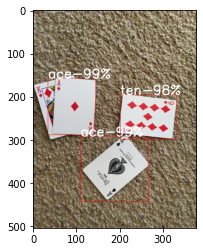

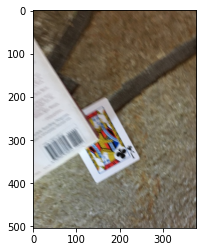

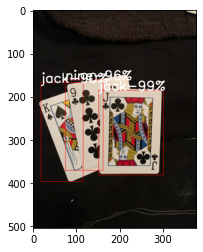

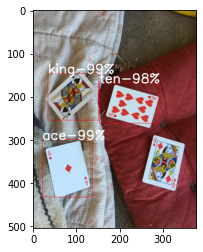

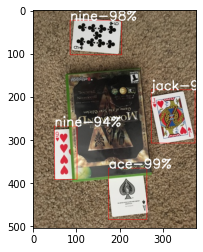

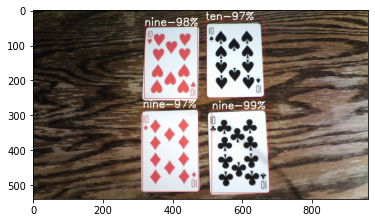

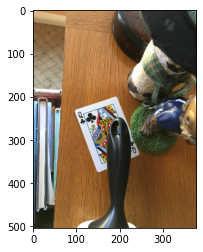

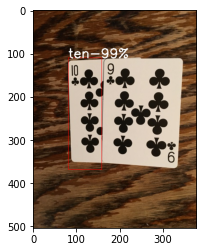

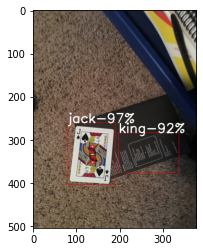

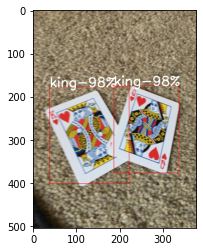

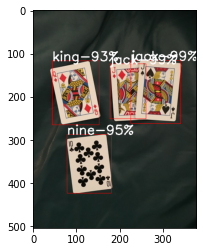

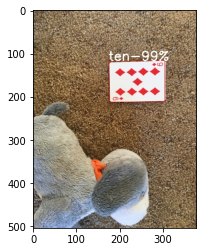

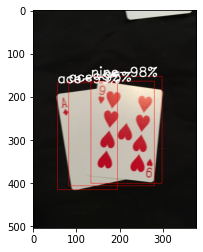

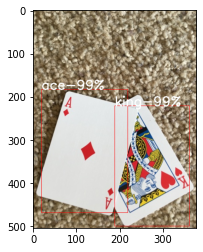

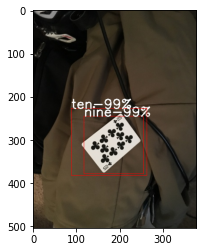

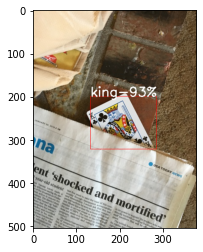

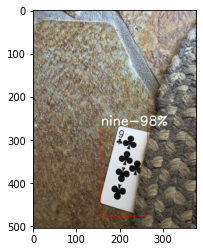

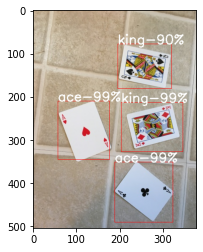

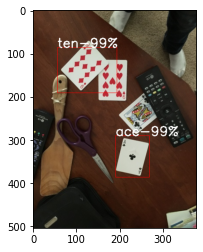

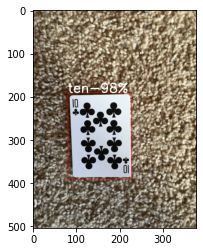

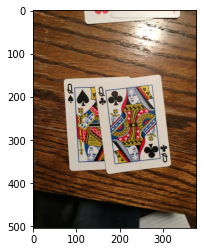

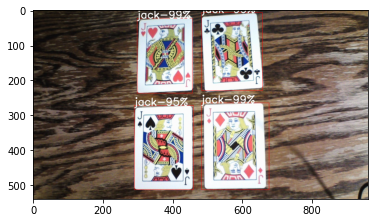

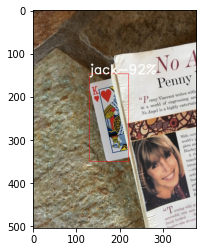

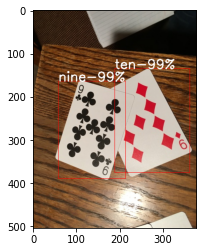

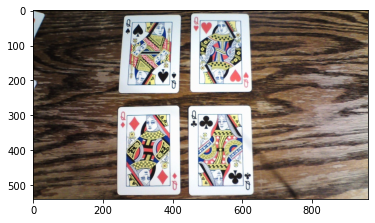

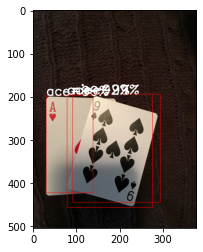

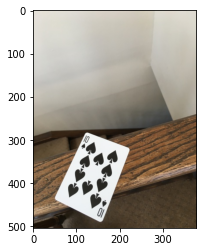

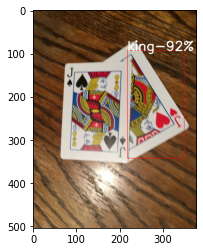

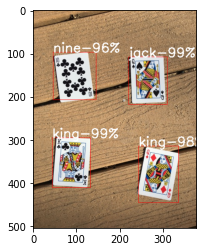

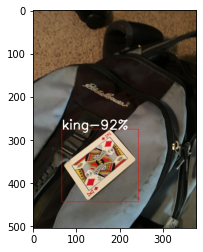

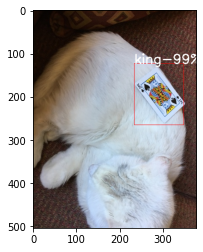

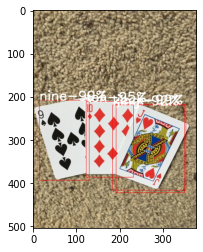

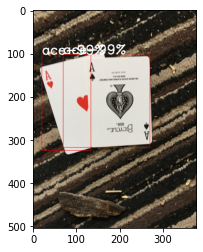

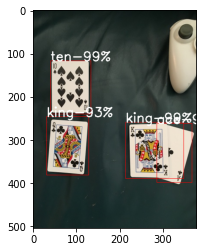

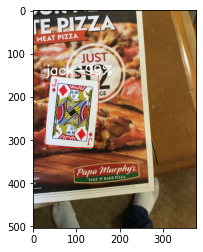

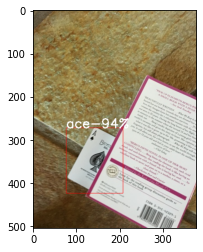

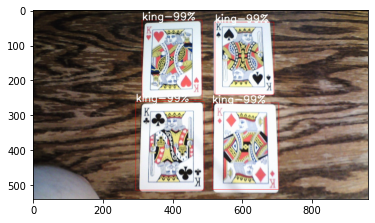

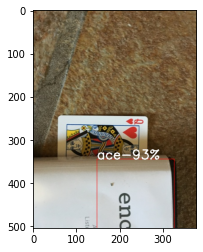

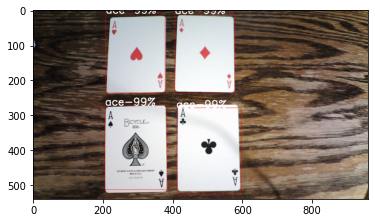

In [ ]:
data = tqdm(test_loader, leave=False)
for batch in data:
  with torch.no_grad():
    images, targets = batch
    images = list(img.to(DEVICE) for img in images)
    output = model(images)
  img = images[0].permute(1, 2, 0).cpu().numpy()
  bboxes = output[0]['boxes'].cpu().numpy().astype(int)
  
  for label, score, bbox in zip(output[0]['labels'], output[0]['scores'],output[0]['boxes']):
      if score < 0.9: break
      x1, y1, x2, y2 = bbox
      cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255))
      cv2.putText(img,LABELS[label]+"-"+str(int(score.item()*100))+"%", 
      (x1, y1), 
      font, fontScale, fontColor, lineType)
  plt.figure()

  plt.imshow(np.array(img[:, :, ::-1]))
  # no warnings
  # plt.imshow((img[:, :, ::-1]*255).astype(np.uint8))

### Данную модель можно использовать в стримах карточных игр. Например для определения карт, как представленно на картинке ниже.

In [ ]:
%%html
<img src='https://poker.ua/wp-content/uploads/d5t555t5.jpg' />